# Experiment

### Detailed Results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)

NUM_LOGS = 101876733
NUM_REGEX = 132
NUM_REP = 1
ns = [4, 8, 16, 32, 64, 96, 192, 256, 512]
grams = ['bigram', 'trigram', 'fourgram', 'baseline']
gram_label = {
    'bigram': '2',
    'trigram': '3',
    'fourgram': '4'
}
grams_fp = grams[:-1]
INDEX_HEADERS = ['NGram', 'Num_Indexed', 'bitvector_index_building_time', 'bitvector_index_size', 'inverted_index_building_time', 'inverted_index_size_fit', 'inverted_index_size']
DIR_NAME = 'out_8_full_combined'
PLOT_BASELINE=True
BAR_WIDTH=0.6
USE_LOG_SCALE = False

In [2]:
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
# index building time
bt_df = pd.read_csv(f'{DIR_NAME}/index_building.csv', names=INDEX_HEADERS)  

In [5]:
nlist = [gram_label[gname] for gname in bt_df['NGram'].to_list()]
bt_df['n'] = nlist

In [6]:
bt_df.head(10)

,NGram,Num_Indexed,bitvector_index_building_time,bitvector_index_size,inverted_index_building_time,inverted_index_size_fit,inverted_index_size,n
0,bigram,64,511.584,815013888,573.147,7462201268,1537228680271329548,2
1,trigram,64,589.552,815013888,638.380,3331135176,1537228676140263456,3
2,fourgram,64,612.694,815013888,682.048,2058850808,1537228674867979088,4
3,bigram,4,445.201,815013888,531.439,728802796,1537228673537931988,2
4,bigram,8,450.849,815013888,555.835,1325485428,1537228674134614620,2
5,bigram,16,459.551,815013888,559.067,2400979168,1537228675210108232,2
6,bigram,32,480.645,815013888,644.843,4374502608,1537228677183631432,2
7,bigram,64,511.869,815013888,572.950,7462201268,1537228680271329548,2
8,bigram,96,550.170,1630027752,596.179,9186846148,1537228681995974428,2
9,bigram,128,539.961,1630027752,572.769,10840192408,1537228683649319648,2


In [7]:
def get_num_bits_masked(df, inverted):
    bit_masks = df['filter'].to_list()
    total_count = 0
    for m in bit_masks:
        if inverted:
            total_count += m.count('0')
        else:
            total_count += m.count('1')
    return total_count

In [8]:
dfs = []
blare_times = []
for fingerprint in grams_fp:
    partial_df = bt_df[bt_df['NGram'] == fingerprint]
    line_remains, bits_masked = [], []
    bit_bt_mean, bit_bt_se = [], []
    inv_bt_mean, inv_bt_se = [], []
    bt_size, inv_size = [], []
    ft_mean, ft_se, total_matched = [], [], []
    inv_mean, inv_se = [], []
    
    for num_indexed in ns:
        # for a q-gram signature, with n qgrams indexed,
        
        # list of 10 experiments
        bit_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_building_time']
        inv_bt_times = partial_df[partial_df['Num_Indexed'] == num_indexed]['inverted_index_building_time']
        
        bt_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['bitvector_index_size']
        inv_sizes = partial_df[partial_df['Num_Indexed'] == num_indexed]['inverted_index_size']

        bit_bt_mean.append(np.mean(bit_bt_times))
        inv_bt_mean.append(np.mean(inv_bt_times))
        
        bt_size.append(np.mean(bt_sizes))
        inv_size.append(np.mean(inv_sizes))
        
        bit_bt_se.append(np.std(bit_bt_times, ddof=1)/np.sqrt(len(bit_bt_times)))
        inv_bt_se.append(np.std(inv_bt_times, ddof=1)/np.sqrt(len(inv_bt_times)))
        
        filter_times = []
        invert_times = []
        dir_name = f'{DIR_NAME}/new_{fingerprint}_{num_indexed}'
        
        # Summary csv
        f_name = os.path.join(dir_name, 'summary0.csv')
        sum_df = pd.read_csv(f_name, sep='\t', dtype={'filter': str})
        
        line_remains.append(sum_df['num_after_filter'].sum())
        bits_masked.append(get_num_bits_masked(sum_df, inverted=True))
        curr_filter_matched = sum_df['match_num_filter'].sum()
        curr_invert_matched = sum_df['match_num_inverted'].sum()
        curr_invert2_matched = sum_df['match_num_direct'].sum()
        assert(curr_filter_matched == curr_invert_matched)
        
        total_matched.append(curr_filter_matched)
        
        for subf in os.listdir(dir_name):
            if fingerprint in subf:
                f_name = os.path.join(dir_name, subf)
                df = pd.read_csv(f_name, sep='\t')
                filter_times.append(df['filter_time'].sum())
                direct_times.append(df['direct_time'].sum())
                invert_times.append(df['inverted_time'].sum())
        if len(filter_times) >= 3:
            filter_times = sorted(filter_times)[1:-1]
            invert_times = sorted(invert_times)[1:-1]
        ft_mean.append(np.mean(filter_times))
        ft_se.append(np.std(filter_times, ddof=1)/np.sqrt(len(filter_times)))
        inv_mean.append(np.mean(invert_times))
        inv_se.append(np.std(invert_times, ddof=1)/np.sqrt(len(invert_times)))
        
    curr_df = pd.DataFrame(list(zip(ns, line_remains, bits_masked, 
                                    bit_bt_mean, bit_bt_se,
                                    inv_bt_mean, inv_bt_se,
                                    bt_size, inv_size,
                                    ft_mean, ft_se, 
                                    inv_mean, inv_se,
                                    total_matched)), 
                           columns=['Num_Indexed', 'Log_After_Filter', 'Num_Bits_Masked', 
                                    'Bit_Index_Building_Time_Mean(s)', 'Bit_Index_Building_Time_SE(s)',
                                    'Inverted_Index_Building_Time_Mean(s)', 'Inverted_Index_Building_Time_SE(s)',
                                    'Bit_Index_Size(Byte)', 'Inverted_Index_Size(Byte)',
                                    'Bitvec_Time_Mean(s)', 'Bitvec_Time_SE(s)', 
                                    'Inverted_Time_Mean(s)', 'Inverted_Time_SE(s)', 
                                    'Num_Matched'])
    dfs.append(curr_df)    
blare_times = sorted(blare_times)[1:-1]
blare_mean = np.mean(blare_times)
blare_se = np.std(blare_times, ddof=1)/np.sqrt(len(blare_times))

In [9]:
dfs64 = []
for curr_df in dfs:
    dfs64.append(curr_df[curr_df['Num_Indexed'] == 64])
df64 = pd.concat(dfs64, ignore_index=True)
df64.insert(0, "N-Gram", [gram_label[gram] for gram in grams[:-1]])

In [11]:
# percentage of log after filter for each regex
log_after_filter = 100*df64['Log_After_Filter']/(NUM_LOGS*NUM_REGEX)
log_after_filter

0    0.626785
1    0.576579
2    4.990034
Name: Log_After_Filter, dtype: float64

In [12]:
dfs128 = []
for curr_df in dfs:
    dfs128.append(curr_df[curr_df['Num_Indexed'] == 128])
df128 = pd.concat(dfs128, ignore_index=True)
df128.insert(0, "N-Gram", grams[:-1])
100*df128['Log_After_Filter']/(NUM_LOGS*NUM_REGEX)

0    0.117567
1    0.348514
2    3.131726
Name: Log_After_Filter, dtype: float64

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161']
[3.4999999999999996, 0.6, 0.6, 0.6]


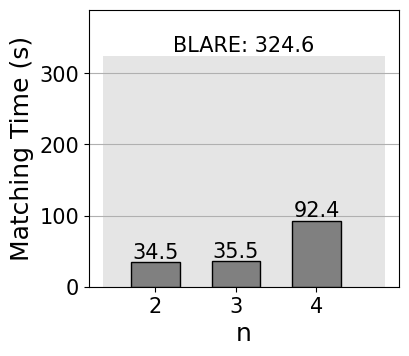

In [25]:
colors = sns.color_palette('colorblind', df64.shape[0]*2)  

fig, ax = plt.subplots(figsize=(4,3.6))

x = np.arange(len(colors))  # the label locations
plt.grid(axis='y')

if PLOT_BASELINE:
    y_est = [blare_mean] * len(x)
    y_err = [blare_se] * len(x)    
    width = df64.shape[0] -0.5 # the width of the bars
    rects = ax.bar([x[0]+0.44*width], [blare_mean], width+1, color='gray', label='BLARE-RE2', alpha=0.2)

color_map=colors[:df64.shape[0]]
ax.bar(df64['N-Gram'], df64['Bitvec_Time_Mean(s)'], yerr=df64['Bitvec_Time_SE(s)'], width=BAR_WIDTH, color='gray', edgecolor='black')#, label=gram)
for c in ax.containers[0:-1:2]:
    ax.bar_label(c, fmt='BLARE: '+'%.1f')
ax.bar_label(ax.containers[-1], fmt='%.1f')
print([p.get_width() for p in ax.patches])

maxy = np.max(df64['Bitvec_Time_Mean(s)'].to_list())
if PLOT_BASELINE:
    maxy = np.max([blare_mean,maxy])
maxy = 1.2*maxy
if USE_LOG_SCALE:
    plt.yscale('log')
    plt.ylim( (pow(10,-1),pow(10,np.log10(maxy))) )
else:
    plt.ylim(0, maxy)

ax.set_xlabel('n')
ax.set_ylabel(f'Matching Time (s)')

plt.savefig('figs/typeNgram_64_match.pdf', bbox_inches = 'tight')

plt.show()

[3.4999999999999996, 0.6, 0.6, 0.6]


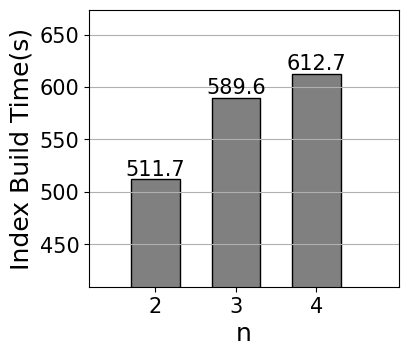

In [24]:
fig, ax = plt.subplots(figsize=(4,3.6))

# for width alignment
width = df64.shape[0] -0.5 # the width of the bars
rects = ax.bar([x[0]+0.44*width], [0], width+1, color='gray', label='', alpha=0)

ax.bar(df64['N-Gram'], df64['Bit_Index_Building_Time_Mean(s)'], width=BAR_WIDTH, color='grey', edgecolor='black')#, label=gram)
plt.grid(axis='y')


for c in ax.containers[0:-1:2]:
    ax.bar_label(c, fmt='BLARE: '+'%.1f')
ax.bar_label(ax.containers[-1], fmt='%.1f')

maxy = 1.1*np.max(df64['Bit_Index_Building_Time_Mean(s)'].to_list())
miny = 0.8*np.min(df64['Bit_Index_Building_Time_Mean(s)'].to_list())
plt.ylim(miny, maxy)
print([p.get_width() for p in ax.patches])

ax.set_ylabel('Index Build Time(s)')
ax.set_xlabel('n')

plt.savefig('figs/typeNgram_64_index.pdf', bbox_inches = 'tight')

plt.show()